## Modules

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import patches, ticker
import seaborn as sns
import os
import geopandas
import cartopy.crs as ccrs
import cartopy
import numpy as np
import shapely

## Paths

In [17]:
WILDCARDS = ["all", "chromosome", "full", "30"]
project_dir = "/mnt/c/Users/ktmea/Projects/plague-phylogeography-projects/denmark/"
results_dir = project_dir

READS_ORIGIN = WILDCARDS[0]
LOCUS_NAME = WILDCARDS[1]
PRUNE = WILDCARDS[2]
MISSING_DATA = WILDCARDS[3]

CURRENT_YEAR = 2021
BURNIN = 0.1

# ------------------------------------------
# Geo
CRS = "epsg:3857"
#CRS_EPSG = ccrs.epsg('3857')
#world_polygons = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres"))

In [18]:
metadata_path       = project_dir + "metadata/{}/site_metadata.txt".format(READS_ORIGIN)
beast_log_path      = project_dir + "beast/{}/chromosome/full/filter{}/relaxed_clock/dates/run/beast_log.tsv".format(READS_ORIGIN, MISSING_DATA)
out_dir             = project_dir + "beast/{}/chromosome/full/filter{}/relaxed_clock/dates/run/".format(READS_ORIGIN, MISSING_DATA)

## Metadata

In [19]:
site_df = pd.read_csv(metadata_path, sep="\t", encoding="latin-1")
#site_df.sort_values(by="date_start", inplace=True)

# Add site numbering
site_dict = {}
site_numbers = []
site_i = 0

for rec in site_df.iterrows():
    site_code = rec[1]["code"]
    if site_code not in site_dict:
        site_i += 1
        number = site_i
        site_dict[site_code] = site_i
    else:
        number = site_dict[site_code] 
    site_numbers.append(number)
    
    if rec[1]["positive"] > 0:
        site_df.at[rec[0],"positive_color"] = "#ff7f0e"
    else:
        site_df.at[rec[0],"positive_color"] = "#1f77b4"

site_df["number"] = site_numbers
site_df.fillna("NA", inplace=True)
site_df = site_df[site_df["date_start"] != "NA"]

# Convert to int
site_df["date_start"] = [int(date) for date in site_df["date_start"]]
site_df["date_end"] = [int(date) for date in site_df["date_end"]]
display(site_df)


,region,date_start,date_end,name,code,n,positive,lat,lon,positive_color,number
0,Ribe,900,999,Ribe Lindegärden,ASR 13II,15,0,55.3281,8.7577,#1f77b4,1
1,Ribe,1250,1550,Ribe Lindegärden,ASR 13II,9,0,55.3281,8.7577,#1f77b4,1
2,Ribe,1350,1550,Ribe Lindegärden,ASR 13II,18,1,55.3281,8.7577,#ff7f0e,1
4,Ribe,900,999,Ribe Lindegärden,ASR 2391,4,0,55.3281,8.7577,#1f77b4,2
6,Ribe,1150,1349,Ribe Gräbrødre,ASR 1015,7,0,55.3281,8.7577,#1f77b4,3
7,Ribe,1250,1550,Ribe Gräbrødre,ASR 1015,1,0,55.3281,8.7577,#1f77b4,3
8,Ribe,1350,1550,Ribe Gräbrødre,ASR 1015,42,5,55.3281,8.7577,#ff7f0e,3
10,Viby,1150,1349,Nordby,FHM 3970,35,0,56.0761,10.2077,#1f77b4,4
12,Horsens,1250,1349,Ole Wormsgade,HOM 1649,7,0,55.8606,9.8477,#1f77b4,5
14,Horsens,1250,1450,Sejet,HOM 1046,14,1,55.8606,9.8477,#ff7f0e,6


## BEAST Log

In [20]:
log_df = pd.read_csv(beast_log_path, sep="\t", index_col="Sample")

# Discard burnin
burnin_states = round(len(log_df) * BURNIN)
log_df = log_df.iloc[burnin_states:]


danish_samples = {
    "D62" : "G25A",    
    "D71" : "G16", 
    "R36" : "G25B x98",    
    "P387" : "A1480 x1480",
    "P187" : "A146 x3011",    
    "P212" : "G371",
    "D72" : "G207",     
    "D75" : "G861 x1035",         
    "D51" : "Gr GC 15" ,    
    
}
columns = ["height({})".format(sample) for sample in danish_samples]
danish_tip_df = log_df[columns]

# Convert to calendar year
for col in danish_tip_df:
    bp_years = list(danish_tip_df[col])
    calendar_years = [CURRENT_YEAR - year for year in bp_years]
    danish_tip_df[col] = calendar_years

danish_tip_df.columns = list(danish_samples.values())

# Find oldest sample
danish_min_mean = CURRENT_YEAR
danish_max_mean = -CURRENT_YEAR

for column in danish_tip_df:
    mean_date = sum(danish_tip_df[column]) / len(danish_tip_df[column])
    if mean_date < danish_min_mean:
        danish_min_mean = mean_date
    if mean_date > danish_max_mean:
        danish_max_mean = mean_date
        
danish_violin_df = pd.DataFrame({"sample": [], "date": [], })
for column in danish_tip_df.columns:
    dates = list(danish_tip_df[column])
    samples = [column] * len(dates) 
    data_df = pd.DataFrame({"date" : dates, "sample" : samples})
    danish_violin_df = danish_violin_df.append(data_df, ignore_index=True)

/home/ktmeaton/miniconda3/envs/plague-phylogeography/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


## Intersection

In [21]:
min_date = min(site_df["date_start"])
max_date = max(site_df["date_end"])
interval_date = 1

date_n_dict = {}

for date in range(min_date, max_date + interval_date, interval_date):
    date_n_dict[date] = 0
    
    
for rec in site_df.iterrows():
    date_start = rec[1]["date_start"]
    date_end = rec[1]["date_end"]
    n = rec[1]["n"]       
        
    for date in date_n_dict:        

        date_next = date + interval_date
        if date_start >= date and date_start < date_next:
            date_n_dict[date] += n

        elif date_start < date and date_end >= date:
            date_n_dict[date] += n
            
#print(date_n_dict)

## Plot

1 15.0
-29.0 9.0
-47.0 18.0
-83.0 4.0
-91.0 7.0
-105.0 1.0
-107.0 42.0
-191.0 35.0
-261.0 7.0
-275.0 14.0
-303.0 11.0
-325.0 7.0
-339.0 19.0
-377.0 4.0
-385.0 6.0
-397.0 21.0
-439.0 2.0
-443.0 8.0
-459.0 2.0
-463.0 2.0
-467.0 13.0
-493.0 50.0
{1: 'Ribe Lindegärden', -29.0: '', -47.0: '', -83.0: '', -91.0: 'Ribe Gräbrødre', -105.0: '', -107.0: '', -191.0: 'Nordby', -261.0: 'Ole Wormsgade', -275.0: 'Sejet', -303.0: 'Tirup', -325.0: 'Hågerup', -339.0: 'Refshale', -377.0: 'Sct. Michael', -385.0: 'The Catholic Church', -397.0: 'Sct. Mathias', -439.0: '', -443.0: 'Sct. Drotten', -459.0: 'Faldborg', -463.0: '', -467.0: '', -493.0: 'Monastery Church'}


[Text(0, 1.0, 'Ribe Lindegärden'),
 Text(0, -29.0, ''),
 Text(0, -47.0, ''),
 Text(0, -83.0, ''),
 Text(0, -91.0, 'Ribe Gräbrødre'),
 Text(0, -105.0, ''),
 Text(0, -107.0, ''),
 Text(0, -191.0, 'Nordby'),
 Text(0, -261.0, 'Ole Wormsgade'),
 Text(0, -275.0, 'Sejet'),
 Text(0, -303.0, 'Tirup'),
 Text(0, -325.0, 'Hågerup'),
 Text(0, -339.0, 'Refshale'),
 Text(0, -377.0, 'Sct. Michael'),
 Text(0, -385.0, 'The Catholic Church'),
 Text(0, -397.0, 'Sct. Mathias'),
 Text(0, -439.0, ''),
 Text(0, -443.0, 'Sct. Drotten'),
 Text(0, -459.0, 'Faldborg'),
 Text(0, -463.0, ''),
 Text(0, -467.0, ''),
 Text(0, -493.0, 'Monastery Church')]

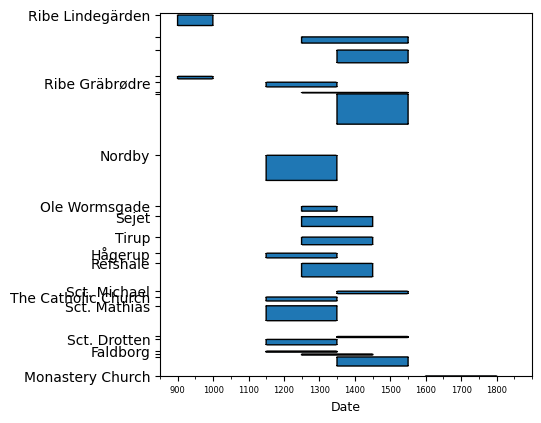

In [84]:
# ---------------------------------------
# PLOT SETUP
TARGET_RES = [480, 480]
DPI=100
FIGSIZE=[TARGET_RES[0] / DPI, TARGET_RES[1] / DPI]
FONTSIZE=12

# Setup figure and axis
num_sites = len(set(site_df["name"]))
fig, axes = plt.subplots(1, figsize=FIGSIZE, dpi=DPI, sharex=True)
fig.subplots_adjust(hspace=0)

xticks = list(range(min(site_df["date_start"]),max(site_df["date_end"]) + 100, 100))
yticks = {}


# If multiple plots
if type(axes) == np.ndarray:
    ax = axes[0]
else:
    ax = axes
    
i = 1
prev_site = ""
for rec in site_df.iterrows():
    site = rec[1]["name"]
    if site != prev_site:
        yticks[i] = site
    else:
        yticks[i] = ""
    n = rec[1]["n"]
    print(i,n)
    date_start = rec[1]["date_start"]
    date_end = rec[1]["date_end"]
    date_mean = sum([date_start, date_end] ) / 2
    date_err = date_end - date_mean
    y_coord = rec[1]["number"]
       
    color="#1f77b4" # blue
    ax.add_patch(patches.FancyBboxPatch(
        #xy     = (date_start, y_coord), 
        xy     = (date_start, i),
        width  = date_end - date_start, 
        #height = 0.10,
        height = -n,
        boxstyle = "round",
        ec = "black",
        color=color,
    )) 
    prev_site = site
    #i -= 1
    i -= n * 2
    


ax.set_xlabel("Date", fontsize=FONTSIZE * 0.75)
ax.set_xlim(min(site_df["date_start"])-50,max(site_df["date_end"]) + 100)
ax.set_xticks(xticks)
ax.set_xticklabels(xticks, fontsize=FONTSIZE / 2)
ax.xaxis.set_minor_locator(ticker.MultipleLocator(50))
#ax.set_yticks(yticks)
#ax.set_yticklabels(list(range(0, len(yticks))), fontsize=FONTSIZE / 2)

ax.set_ylim(0 - len(yticks),3)
print(yticks)
ax.set_yticks(list(yticks.keys()))
ax.set_yticklabels(list(yticks.values()))
#print(list(yticks.values()))
#ax.set_yticklabels(list(yticks.values()))



/home/ktmeaton/miniconda3/envs/plague-phylogeography/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator


'out_path = os.path.join(out_dir, "site_timeline")\nplt.savefig(out_path + ".png", bbox_inches="tight")\nplt.savefig(out_path + ".svg", bbox_inches="tight")'

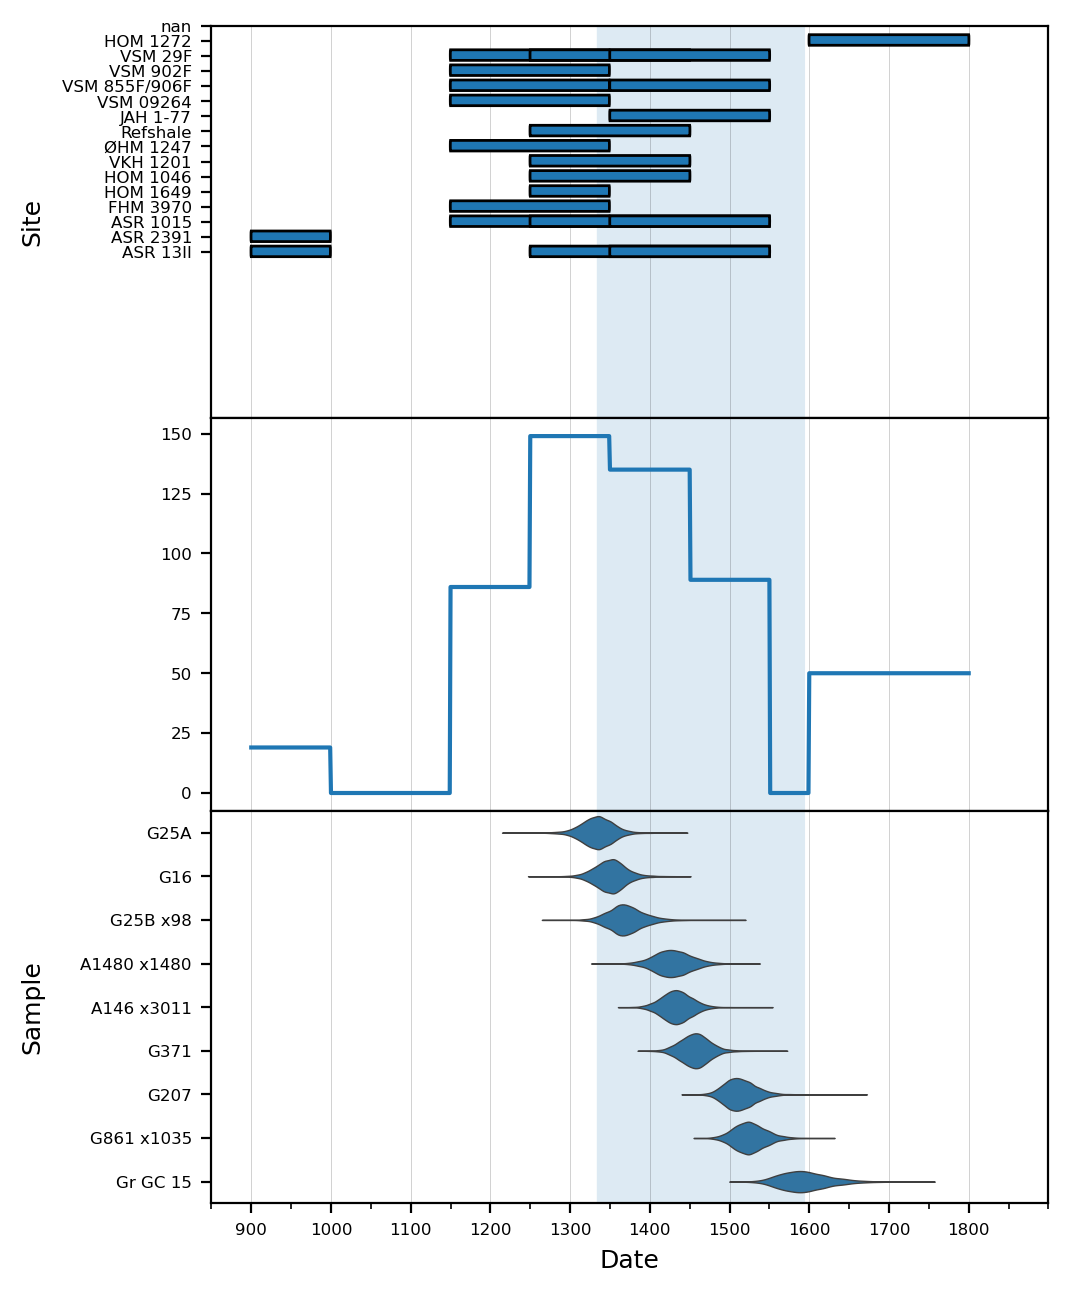

In [75]:
# ---------------------------------------
# PLOT SETUP
TARGET_RES = [1080, 1560]
DPI=200
FIGSIZE=[TARGET_RES[0] / DPI, TARGET_RES[1] / DPI]
FONTSIZE=12

# Setup figure and axis
fig, axes = plt.subplots(3, figsize=FIGSIZE, dpi=DPI, sharex=True)
fig.subplots_adjust(hspace=0)

xticks = list(range(min(site_df["date_start"]),max(site_df["date_end"]) + 100, 100))

# ---------------------------------------
# Violin Plots
ax = axes[len(axes) - 1]

# Plot
sns.violinplot(
    ax=ax, 
    data=danish_violin_df, 
    x="date", 
    y="sample", 
    lw=0.5, 
    color="#1f77b4", #blue
    #olor="#ff7f0e", #orange
    inner=None, 
    zorder=2
)
ax.set_ylabel("Sample", fontsize=FONTSIZE * 0.75)
# Custom styles
ax.set_yticklabels(list(danish_tip_df.columns), fontsize=FONTSIZE / 2)
for collection in ax.collections:
    collection.set_linewidth(0.5)

# ---------------------------------------
# Line graph
ax = axes[len(axes) - 2]
    
# Plot
sns.lineplot(ax=ax, x=list(date_n_dict.keys()), y=list(date_n_dict.values()))
# Customstyles
ax.set_yticklabels([round(t) for t in ax.get_yticks()], fontsize=FONTSIZE / 2)


# ---------------------------------------
# Rect Graph
ax = axes[len(axes) - 3]

# Plot
for rec in site_df.iterrows():
    date_start = rec[1]["date_start"]
    date_end = rec[1]["date_end"]
    y_coord = rec[1]["number"]
    positive = rec[1]["positive"]
       
    color="#1f77b4" # blue
    #if positive > 0:
    #    color="#ff7f0e" # orange
    ax.add_patch(patches.FancyBboxPatch(
        xy     = (date_start, y_coord), 
        width  = date_end - date_start, 
        height = 0.10,
        boxstyle = "round",
        ec = "black",
        color=color,
    ))
    
# Custom Styles
ax.set_ylabel("Site", fontsize=FONTSIZE * 0.75)
ax.set_ylim(0,max(site_df["number"]) + 1)
ax.set_ylim(-10,max(site_df["number"]) + 1)
ax.set_yticks(range(1, len(site_dict) + 1))
ax.set_yticklabels(list(site_dict.keys()), fontsize=FONTSIZE / 2)

# ---------------------------------------
# Annotations

# Bottom xaxis   
axes[-1].set_xlabel("Date", fontsize=FONTSIZE * 0.75)
axes[-1].set_xlim(min(site_df["date_start"])-50,max(site_df["date_end"]) + 100)
axes[-1].set_xticks(xticks)
axes[-1].set_xticklabels(xticks, fontsize=FONTSIZE / 2)
axes[-1].xaxis.set_minor_locator(ticker.MultipleLocator(50))


# Add vertical lines
for ax in axes:
    # Major tick lines
    for tick in xticks:
        ax.axvline(tick, lw=0.25, color="black", alpha=0.25, zorder=0)
    # High prob region
    ax.add_patch(patches.FancyBboxPatch(
        xy     = (danish_min_mean, - 10), 
        width  = danish_max_mean - danish_min_mean, 
        height = 1000,
        boxstyle = "round",
        ec = "none",
        #color="#c4c4c4", #grey
        color="#1f77b4", #blue
        #color="#ff7f0e", #orange
        alpha=0.15,
        zorder=0,
    ))   
    # Align ylabels
    ax.yaxis.set_label_coords(-0.20, 0.5)

"""out_path = os.path.join(out_dir, "site_timeline")
plt.savefig(out_path + ".png", bbox_inches="tight")
plt.savefig(out_path + ".svg", bbox_inches="tight")"""

---
# Mapping

In [ ]:
map_df = pd.DataFrame(columns = ["region","lon","lat","n"])
geometry = []
for region in set(site_df["region"]):
    total_n = float(sum(list(site_df[site_df["region"] == region]["n"])))
    lat = list(site_df[site_df["region"] == region]["lat"])[0]
    lon = list(site_df[site_df["region"] == region]["lon"])[0]
    point = shapely.geometry.Point(lon,lat)
    geometry.append(point)
    
    data = {"region":region, "lon":lon, "lat":lat, "n":total_n}
    map_df = map_df.append(data, ignore_index=True)


map_gdf = geopandas.GeoDataFrame(map_df, crs=CRS, geometry=geometry)
display(map_gdf)


In [ ]:
# ---------------------------------------
# PLOT SETUP
TARGET_RES = [1280, 1280]
DPI=400
FIGSIZE=[TARGET_RES[0] / DPI, TARGET_RES[1] / DPI]
FONTSIZE=12

fig, ax = plt.subplots(1, subplot_kw={'projection': CRS_EPSG},figsize=FIGSIZE, dpi=DPI)

# Basemap
ax.add_feature(cartopy.feature.LAND, edgecolor="black", lw=0.25)
ax.add_feature(cartopy.feature.OCEAN, edgecolor="black", lw=0.25)
ax.add_feature(cartopy.feature.BORDERS, lw=0.25)
ax.add_feature(cartopy.feature.LAKES, edgecolor="black", lw=0.25)
ax.add_feature(cartopy.feature.RIVERS, lw=0.25)
#ax.gridlines(draw_labels=True)

map_gdf.plot(
    ax=ax, 
    markersize="n",
    color="#ff7f0e",
    edgecolor="black",
    lw=0.25,
    transform=ccrs.PlateCarree(),
)

# Text Labels
x_buff = 0.1
for rec in map_df.iterrows():
    n = rec[1]["n"]
    lon = rec[1]["lon"] + x_buff
    lat = rec[1]["lat"]
    name = rec[1]["region"] + ", {}".format(int(n))
    # these are matplotlib.patch.Patch properties
    props = dict(boxstyle='round', facecolor='white', alpha=1.0, lw=0.25)

    # place a text box in upper left in axes coords
    #ax.text(x=lon, y=lat, s=name, transform=ccrs.PlateCarree(), fontsize=FONTSIZE / 4,
    #        verticalalignment='top', bbox=props)

# Denmark focus
ax.set_extent([7, 14, 54, 58])

for spine in ax.spines:
    ax.spines[spine].set_linewidth(0.25)

out_path = os.path.join(out_dir, "site_map")
# Use pdf to help shrink file size
plt.savefig(out_path + ".pdf", bbox_inches="tight")
#plt.savefig(out_path + ".png", bbox_inches="tight")
#plt.savefig(out_path + ".svg", bbox_inches="tight")